# NL-EIG Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the nonlinear system with known eigenpairs.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Nonlinear System with Known Eigenpairs                                                                                                                                                                                                         |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | Principal eigenpairs with feasible residuals                                                                                                                                                                                                   |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |


In [1]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
/home/jianqiang/Downloads/Residual-Dynamic-Mode-Decomposition-1/examples/../ddrv/viz/vis_vector_field_2d.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


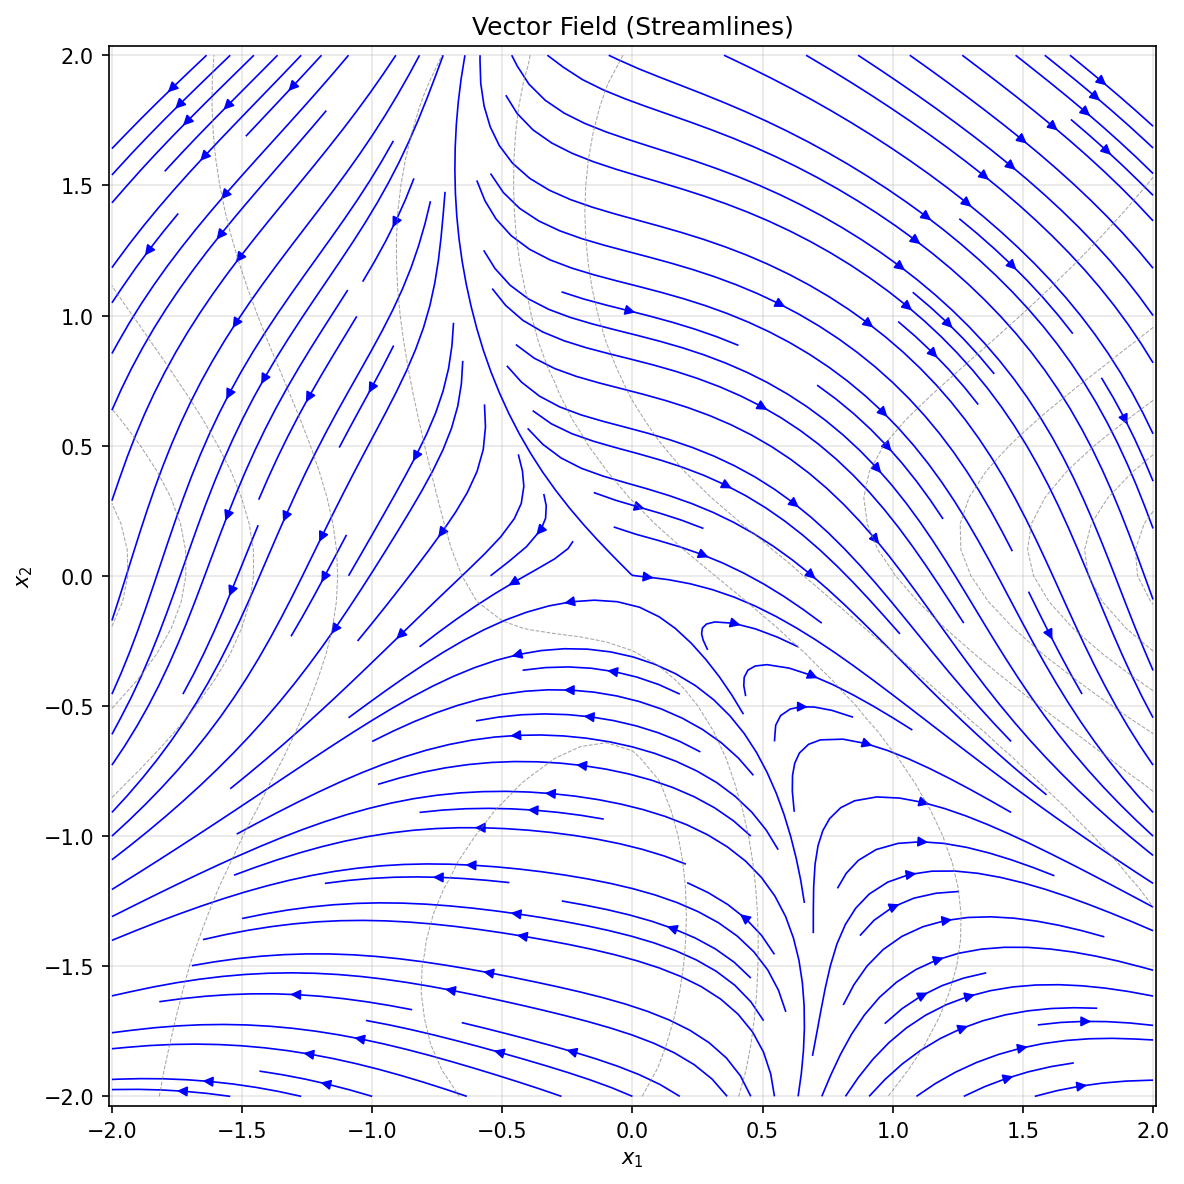

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [2]:
# define the dynamical system
NL_EIG = ddrv.dynamic.NL_EIG(lambda1=-1.0, lambda2=2.5)
ddrv.viz.vis_vector_field_2d(
    NL_EIG.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 10 steps, 0.05 time step...
(11, 1000, 2)


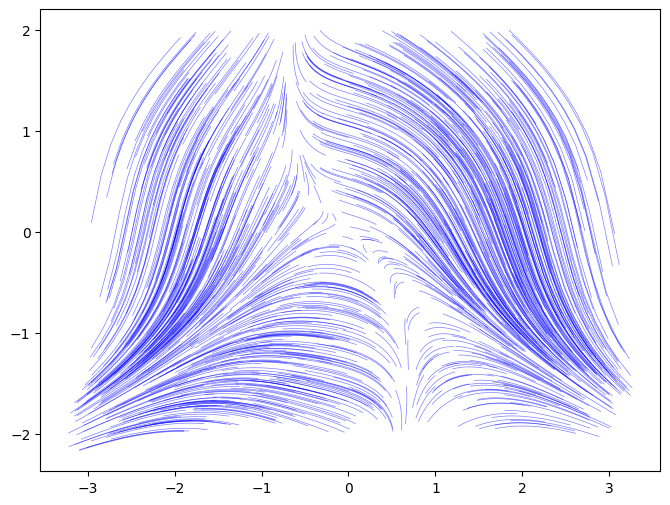

In [3]:
# set the seed for reproducibility


RANDOM_SEED = 42
DT = 0.05


# generate the trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    NL_EIG,
    num_samples=1000,
    num_steps=10,
    dt=DT,
    domain=[[-2, 2], [-2, 2]],
    random_seed=RANDOM_SEED,
)
print(traj_data.shape)

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)

In [4]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(10000, 2) (10000, 2)


In [5]:
# get the principal eigenvalues
print(RANDOM_SEED)
LAM_P_dt, LAM_P_ct = ddrv.common.get_principal_eigenvalues(
    NL_EIG,
    [0, 0],
    0.00001,  # radius for the small neighborhood
    num_samples=5000,
    num_steps=10,
    dt=0.01,
    random_seed=RANDOM_SEED,
)

print("discrete time principal eigenvalues", LAM_P_dt)
print("continuous time principal eigenvalues", LAM_P_ct)

42
generated 5000 trajectories in batch (odeint), 10 steps, 0.01 time step...
(50000, 2) (50000, 2)
(2, 2)
discrete time principal eigenvalues [1.02531523 0.99004982]
continuous time principal eigenvalues [ 2.50001083 -1.00000109]


In [6]:
# get the principal eigenmodes
principal_eigenmodes, observables, residuals = ddrv.common.get_principal_eigenmodes(
    X,
    Y,
    LAM_P_ct,
    DT,
    observe_params={"basis": "poly", "degree": 9},
)

In [12]:
# evaluate the obtained principal eigenmodes on the grid samples
domain = [[-3, 3], [-3, 3]]
x = np.linspace(domain[0][0], domain[0][1], 100)
y = np.linspace(domain[1][0], domain[1][1], 100)
X, Y = np.meshgrid(x, y)
grid_samples = np.vstack([X.flatten(), Y.flatten()]).T
# evaluate the principal eigenmodes on the grid samples
Z_learned = observables.eval_mod(grid_samples, principal_eigenmodes)
print(Z_learned.shape)

# evaluate the ground true eigenfunctions on the grid samples
eigF = NL_EIG.get_numerical_eigenfunctions()
Z_true = eigF(*grid_samples.T).squeeze().T
print(Z_true.shape)

# CAUTION: Z_true is from different order of the principal eigenmodes, so we need to reorder it
Z_true = Z_true[:, [1, 0]]  # now correct order with the principal eigenvalues [-1, 2.5]

# estimate the scaling factor for the first principal mode
scaling_factor_1 = ddrv.common.estimate_scaling_factor(Z_true[:, 0], Z_learned[:, 0])
# estimate the scaling factor for the second principal mode
scaling_factor_2 = ddrv.common.estimate_scaling_factor(Z_true[:, 1], Z_learned[:, 1])

# compute the relative absolute difference of the first principal mode
error_1 = np.abs(Z_true[:, 0] - scaling_factor_1 * Z_learned[:, 0]) / np.abs(
    Z_true[:, 0]
)
# compute the relative absolute difference of the second principal mode
error_2 = np.abs(Z_true[:, 1] - scaling_factor_2 * Z_learned[:, 1]) / np.abs(
    Z_true[:, 1]
)

(10000, 2)
(10000, 2)


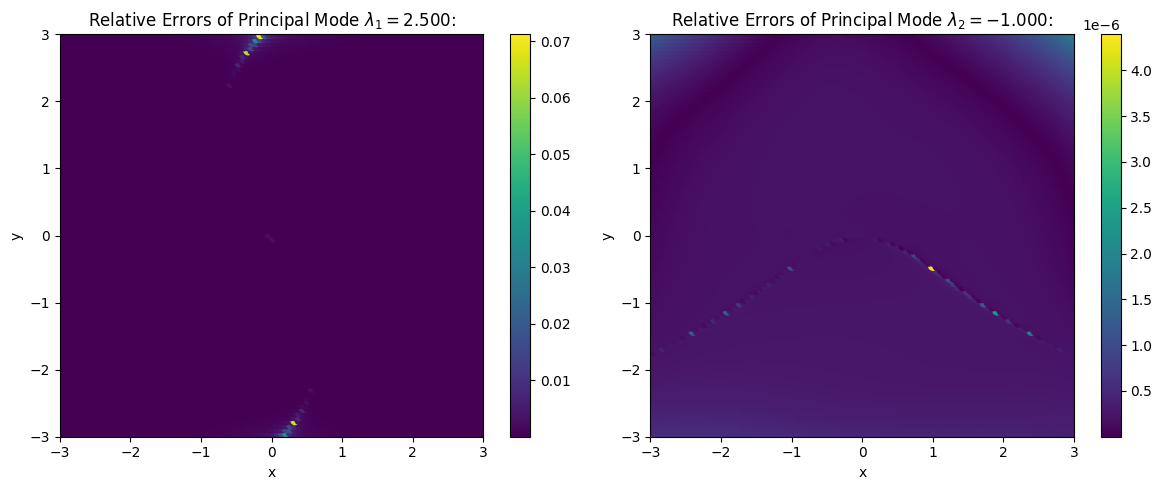

In [13]:
# visualize the distribution of the errors on the domain in two subplots
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# first principal mode error
scatter1 = ax1.scatter(X, Y, c=error_1, cmap="viridis")
ax1.set_title(
    "Relative Errors of Principal Mode $\lambda_1 = {:.3f}$:".format(LAM_P_ct[0])
)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xlim(domain[0])
ax1.set_ylim(domain[1])
plt.colorbar(scatter1, ax=ax1)

# second principal mode error
scatter2 = ax2.scatter(X, Y, c=error_2, cmap="viridis")
ax2.set_title(
    "Relative Errors of Principal Mode $\lambda_2 = {:.3f}$:".format(LAM_P_ct[1])
)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_xlim(domain[0])
ax2.set_ylim(domain[1])
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [14]:
# now with these obtained principal eigenmodes, we can perform reachability verification

# define the initial set, and the target set for reachability verification
X0 = [[0, 0.1], [1.1, 1.2]]
XF = [[1.8, 1.9], [-0.8, -0.7]]

pts_X0 = ddrv.common.sample_box_set(X0, 5000)
pts_XF = ddrv.common.sample_box_set(XF, 5000)
print(pts_X0.shape, pts_XF.shape)
# evaluate the eigenfunctions on the initial set and target set samples
ef0_vals = observables.eval_mod(pts_X0, principal_eigenmodes)
efF_vals = observables.eval_mod(pts_XF, principal_eigenmodes)
print(ef0_vals.shape, efF_vals.shape)
# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efF_vals, LAM_P_ct)
print(time_bounds, status)

(5000, 2) (5000, 2)
(5000, 2) (5000, 2)
[np.float64(0.7617266044332157),np.float64(0.8828327504169774)] bound_mag
[(np.float64(0.7617266044332157), np.float64(0.8828327504169774))] ('PROBABLY REACHABLE', 1)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


finshed simulation


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


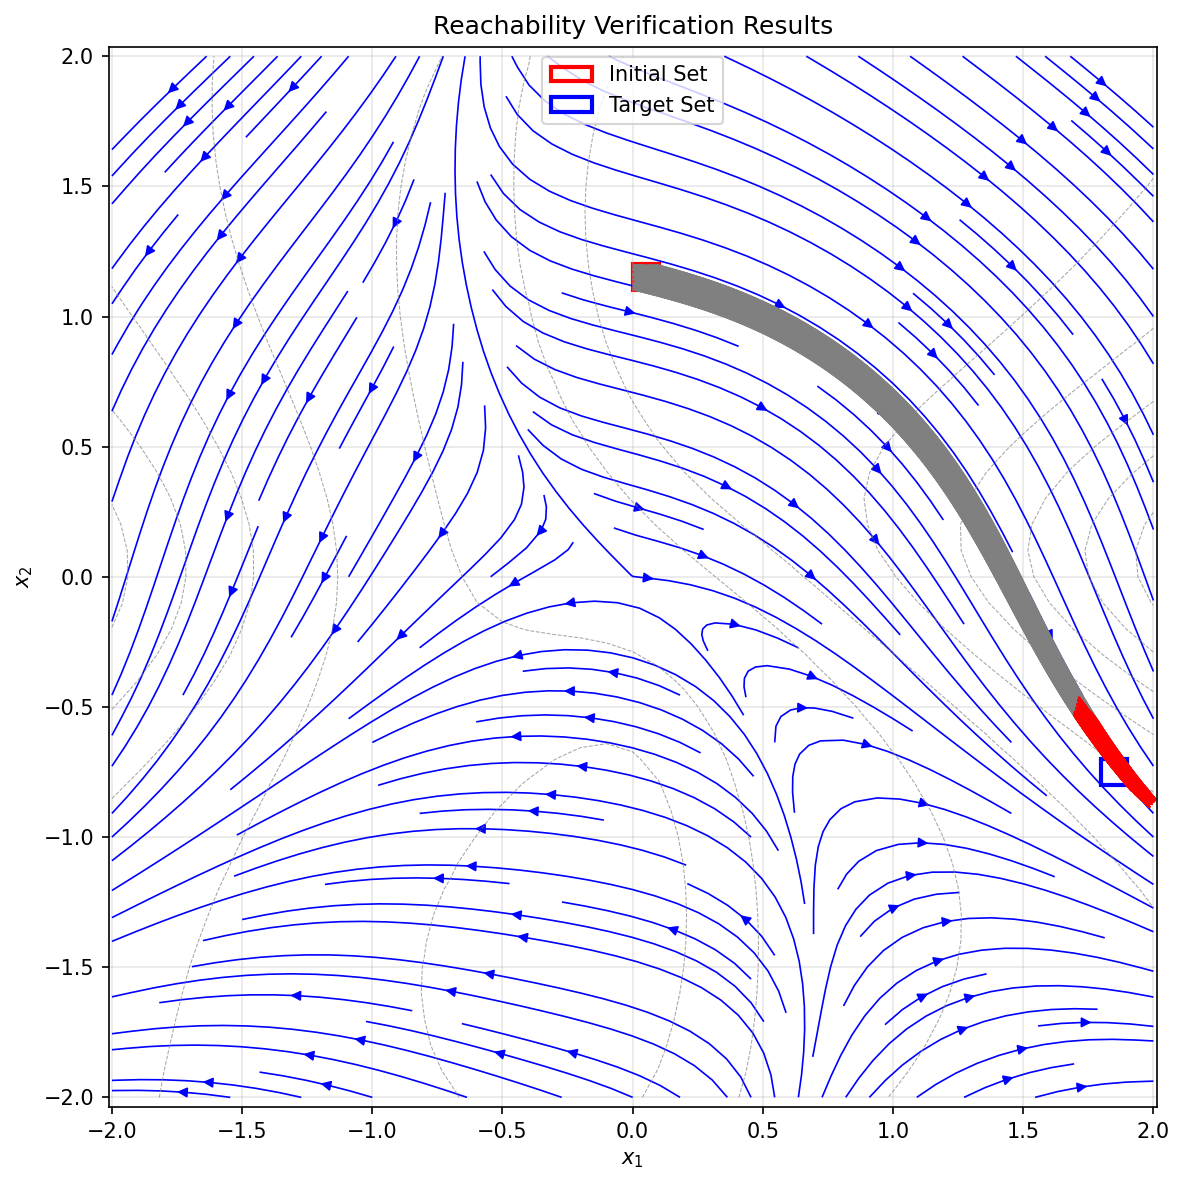

In [15]:
# visualize the reachability result
ddrv.viz.vis_rv(
    NL_EIG.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    bounds=time_bounds,
    dt=0.01,
    initial_set=X0,
    target_set=XF,
)